In [1]:
import numpy as np
from numpy import random
import gensim
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
%matplotlib inline



C:\Users\bertille.lekeufack\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#df=pd.read_excel('final_210504_tous labels.xlsx',engine='openpyxl')
#df=pd.read_csv("Consumer_Complaints.csv")
df=pd.read_excel('message_cord_1001.xlsx',engine='openpyxl')

In [16]:
df=df[1001:1640]
#df=df.head(500)

In [ ]:
#df = df[pd.notnull(df['Consumer complaint narrative'])]

In [ ]:
#col = ['Product', 'Consumer complaint narrative']
#df = df[col]

In [ ]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [ ]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [ ]:
df=df.rename(columns={"Product": "catégorie", "Consumer_complaint_narrative": "Messages"})

In [ ]:
#df = df.drop(['Date de création',  'Date de modification','Nom du fichier'], axis=1)

In [ ]:
df['Messages']=df['Messages'].astype(str)

In [17]:
stopwords = nltk.corpus.stopwords.words('french')
vect = TfidfVectorizer(stop_words=stopwords, max_df=0.50, min_df=2)
X = vect.fit_transform(df.Messages)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [18]:
df['cat'] = df['catégorie'].replace({ 'contrat' : 0,'demande de renseignement' : 1,'interne Axxès' : 2 ,'facture' : 3, 'commande de badge' : 4, 'réclamation qualité de service' : 5,'facture' : 6,
                                            'badge':7})

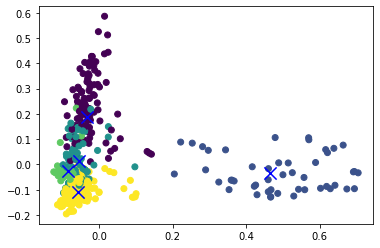

In [19]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans

random_state = 1
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)

cls.fit(X)
cls.predict(X)
cls.labels_
pca = PCA(n_components=5)
reduced_features = pca.fit_transform(X.toarray())
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
#X_dense = X.todense()
#coords = PCA(n_components=2).fit_transform(X_dense)
#plt.scatter(coords[:, 0], coords[:, 1], c='m',)
#plt.show()


In [ ]:
X = ['facture', 'badge', 'demande de renseignement', 'contrat',
       'identifiant', 'commande de badge',
       'réclamation qualité de service', 'interne Axxès']

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=df['catégorie'])
fig.show()
df.catégorie.unique()

In [ ]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
features = vect.get_feature_names()
print (top_feats_in_doc(X, features, 1, 20))

In [ ]:
def top_mean_feats(X, features,
 grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:
print(top_mean_feats(X, features, top_n=10))


In [ ]:
from sklearn.cluster import KMeans
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
label = clf.fit_predict(X)

In [ ]:
from sklearn.manifold import TSNE
centroids = clf.cluster_centers_

random_state = 1
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model.fit_transform(centroids)
print(transformed_centroids)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
from numpy import concatenate
# we want to transform the rows and the centroids

centroids = clf.cluster_centers_
everything = concatenate((X.todense(), centroids))
random_state = 1
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 10
model = TSNE(n_components=2, random_state=random_state, init=tsne_init,
    perplexity=tsne_perplexity,
    early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_everything = model.fit_transform(everything)
print(transformed_everything)
plt.scatter(transformed_everything[:-n_clusters, 0], transformed_everything[:-n_clusters, 1], marker='x')
plt.scatter(transformed_everything[-n_clusters:, 0], transformed_everything[-n_clusters:, 1], marker='o')

plt.show()

In [ ]:
import gc
gc.get_objects()

In [ ]:
gc.collect()


In [ ]:
del 

In [ ]:
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.show()

In [ ]:
type(r1)

In [ ]:
u_labels = np.unique(label)
#label = list(map(float, label[0].split("*")))
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[label == i, 0],X[label == i, 1])
plt.legend()
plt.show()

In [ ]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs


In [ ]:
print(top_feats_per_cluster(X, y, features, top_n=10))